## Notebook 3: Callbacks, Hooks & Training

Objective: Learn about PyTorch Lightning Callbacks, implement built-in and
           custom callbacks, set up and run a full training loop using the
           Trainer, and export the model using TorchScript.

Dataset directory: /home/mbenimam/Documents/work/neubias/data/Regions
Found 4 classes: ['Fibrotic', 'Mucin', 'Necrotic', 'TumorIslet']
Class to index mapping: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Defined train_transforms and val_test_transforms.
Data directory check passed: /home/mbenimam/Documents/work/neubias/data/Regions
Setting up data for stage: None
Scanning for all image paths and string labels...
Found 2516 total images.
Dataset split completed.
Train size: 1761, Val size: 377, Test size: 378
Initialized Dataset. Label map: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Initialized Dataset. Label map: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Initialized Dataset. Label map: {'Fibrotic': 0, 'Mucin': 1, 'Necrotic': 2, 'TumorIslet': 3}
Datasets instantiated.

Visualizing batch from Training DataLoader (via DataModule):
Index-to-class map not provided.


/home/mbenimam/Documents/work/neubias/src/utils.py:188: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=30, p=0.5, border_mode=cv2.BORDER_REFLECT, value=0),
/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


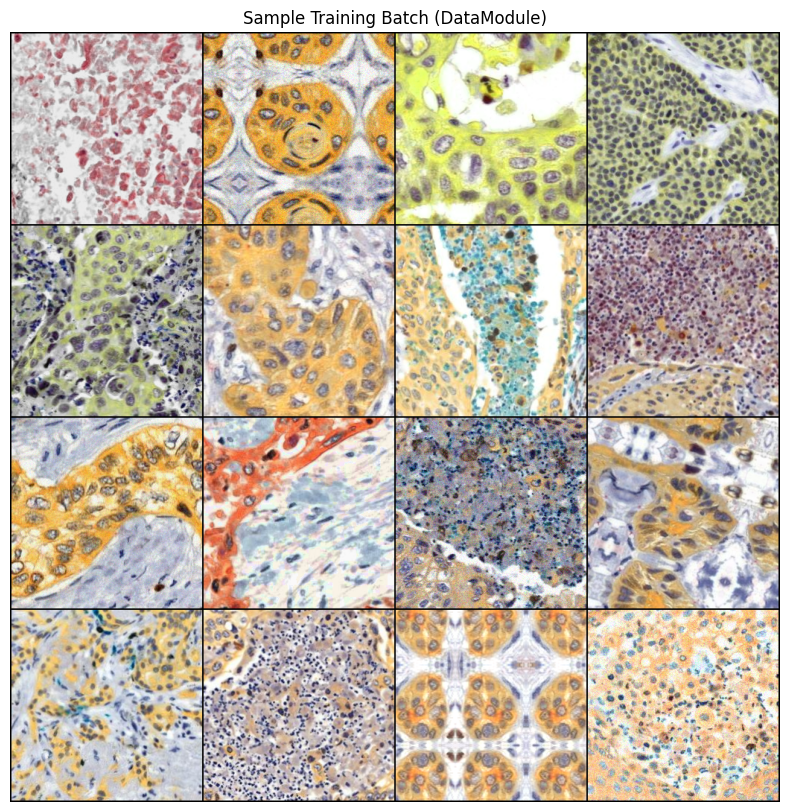

Labels for displayed batch:
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

Visualizing batch from Validation DataLoader (via DataModule):
Index-to-class map not provided.


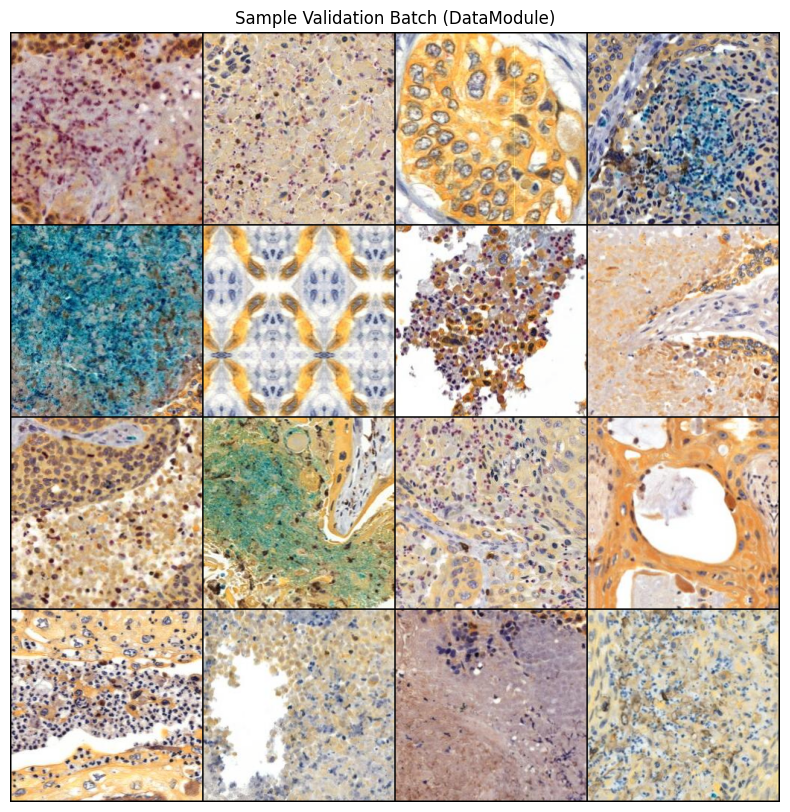

Labels for displayed batch:
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

Visualizing batch from Test DataLoader (via DataModule):
Index-to-class map not provided.


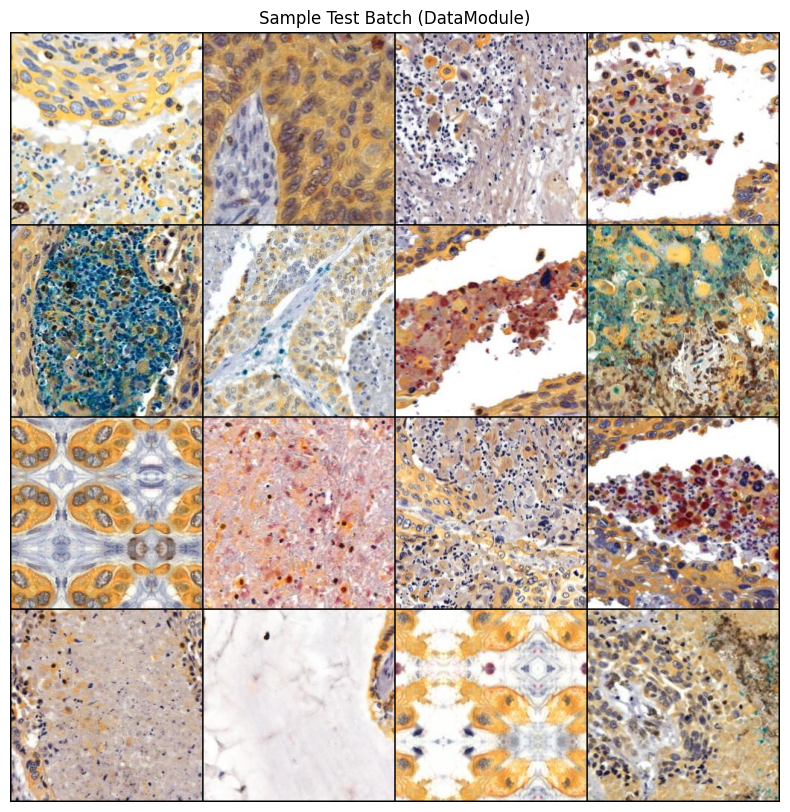

Labels for displayed batch:
['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']


In [1]:
%load_ext autoreload
%autoreload 2
# --- Imports ---
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import os
import sys
sys.path.append(os.path.abspath('../src'))

from utils import *


# --- Configuration (Placeholders - Load these properly) ---
# These would typically come from config files, CLI args, or imported modules
CHECKPOINT_DIR = "./lightning_checkpoints"
LOG_DIR = "./lightning_logs"
NUM_CLASSES = 4
LEARNING_RATE = 1e-4
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15



# Example: Assume these are loaded or defined
# class_to_idx = {'TER': 0, 'Necrotic': 1, ...} # Load from previous step or config
DATA_DIR = os.path.abspath('../data/Regions/')

class_names, num_classes, class_to_idx, idx_to_class = get_dataset_info(DATA_DIR)  # Assuming this function returns the necessary info
train_transforms, val_test_transforms = get_transforms()  # Assuming get_transforms() is a function that returns both

# --- Data Module ---
data_module = PatchDataModule(
    data_dir=DATA_DIR,
    class_to_idx=class_to_idx, # Use the map created in the config cell
    train_transform=train_transforms,
    val_test_transform=val_test_transforms,
    batch_size=32,
    num_workers=4, # Adjust based on your system
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)
# Update idx_to_class map from the DataModule's potential map
idx_to_class_from_module = data_module.get_idx_to_label()
# --- Trigger the setup process ---
# This performs the splitting and creates the internal datasets
data_module.prepare_data() # Check if data dir exists
data_module.setup()        # Perform split and dataset creation

# --- Get DataLoaders from the module ---
train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()
test_dl = data_module.test_dataloader() # For later


if train_dl:
    print("\nVisualizing batch from Training DataLoader (via DataModule):")
    show_batch_grid(train_dl, title="Sample Training Batch (DataModule)", idx_map=idx_to_class_from_module)
else:
    print("\nCannot visualize training batch as train_dl is None.")

if val_dl:
    print("\nVisualizing batch from Validation DataLoader (via DataModule):")
    # Note: Validation batches won't show augmentations like flips/rotations
    show_batch_grid(val_dl, title="Sample Validation Batch (DataModule)", idx_map=idx_to_class_from_module)

if test_dl:
    print("\nVisualizing batch from Test DataLoader (via DataModule):")
    show_batch_grid(test_dl, title="Sample Test Batch (DataModule)", idx_map=idx_to_class_from_module)
else:
    print("\nCannot visualize validation batch as val_dl is None.")


## 📞 Introduction to Callbacks

Callbacks are self-contained programs that can be added to your PyTorch Lightning
`Trainer`. They allow you to add custom logic at various stages of the training
process (e.g., at the beginning/end of an epoch, before/after a batch) without
cluttering your `LightningModule`.

**Why use Callbacks?**
- **Modularity:** Keep training logic separate from model definition.
- **Reusability:** Easily reuse common logic like checkpointing or early stopping across projects.
- **Extensibility:** Hook into specific points in the training loop for monitoring, logging, or other actions.

Lightning provides several useful built-in callbacks, and you can easily create
your own.

### `ModelCheckpoint`

This callback saves your model's weights periodically during training.
Key parameters:
- `dirpath`: Directory to save checkpoints.
- `filename`: Naming pattern for checkpoint files (can include metrics).
- `monitor`: Metric to monitor for saving the 'best' model (e.g., 'val_loss_epoch').
- `mode`: 'min' or 'max' depending on whether the monitored metric should be minimized or maximized.
- `save_top_k`: Save the top 'k' best models according to the monitored metric.
- `save_last`: Save the latest model checkpoint at the end of every epoch.


In [ ]:

# Example configuration for ModelCheckpoint
# Saves the best model based on validation accuracy (higher is better)
checkpoint_callback_acc = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename='best-model-acc-{epoch:02d}-{val_acc:.2f}',
    monitor='val_acc', # Assuming 'val_acc' is logged in LightningModule
    mode='max',
    save_top_k=1, # Save only the single best model
    save_last=True, # Also save the latest model state
    verbose=True
)
# hook for compiling the model jit trace at the end of training
class CompileModelCheckpoint(pl.Callback):
    def on_train_end(self, trainer, pl_module):
        # Compile the model using TorchScript
        if hasattr(pl_module, 'model'):
            pl_module.model = torch.jit.script(pl_module.model)
            print("Model compiled successfully.")
        else:
            print("No model found to compile.")


# Example configuration for ModelCheckpoint
# Saves the best model based on validation loss (lower is better)
# checkpoint_callback_loss = ModelCheckpoint(
#     dirpath=CHECKPOINT_DIR,
#     filename='best-model-loss-{epoch:02d}-{val_loss_epoch:.2f}',
#     monitor='val_loss_epoch', # Monitor the epoch validation loss
#     mode='min',
#     save_top_k=1,
#     save_last=True,
#     verbose=True
# )

print("ModelCheckpoint callbacks configured.")

ModelCheckpoint callbacks configured.


### `EarlyStopping`

This callback stops training early if a monitored metric stops improving,
preventing overfitting and saving computation time.
Key parameters:
- `monitor`: Metric to monitor (e.g., 'val_loss_epoch').
- `mode`: 'min' or 'max'.
- `patience`: Number of epochs to wait for improvement before stopping.
- `min_delta`: Minimum change in the monitored quantity to qualify as an improvement.
- `verbose`: Print messages when stopping.

In [3]:

# Example configuration for EarlyStopping
# Stops training if validation loss doesn't improve for 5 consecutive epochs
early_stopping_callback = EarlyStopping(
    monitor='val_loss_epoch',
    mode='min',
    patience=10, # Increase patience for potentially noisy validation loss
    min_delta=0.001,
    verbose=True
)

print("EarlyStopping callback configured.")

EarlyStopping callback configured.


### `LearningRateMonitor`

Automatically logs the learning rate used by the optimizer(s) at each step or epoch.
Very useful when using learning rate schedulers.
Key parameters:
- `logging_interval`: 'step' or 'epoch'.

In [4]:

lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

print("LearningRateMonitor callback configured.")

LearningRateMonitor callback configured.


In [5]:
# classWeights  Overall: Counter({2: 1611, 3: 670, 1: 127, 0: 108})
classWeights = np.array([108, 127, 1611, 670]) # Adjusted for the number of classes
classWeights = 1 / classWeights
classWeights = classWeights / np.sum(classWeights) # Normalize to sum to 1

plModel = HistologyClassifier(
    encoder_name='resnet18',
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    optimizer='AdamW',
    lr_scheduler='ReduceLROnPlateau',
    pretrained=True,
    classWeights=classWeights, # Use the class weights calculated above
)



/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
LOG_DIR = os.path.abspath('../experiments/lightning_logs')

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback_acc, early_stopping_callback, lr_monitor_callback],
    logger=pl.loggers.TensorBoardLogger(LOG_DIR, name="HistologyClassifier"),
    log_every_n_steps=1,
    enable_progress_bar=True,
    profiler="simple",
    deterministic=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(plModel, data_module)
# Save the final model
final_model_path = os.path.join(CHECKPOINT_DIR, "final_model.ckpt")
trainer.save_checkpoint(final_model_path)
print(f"Final model saved to {final_model_path}")


/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints exists and is not empty.

   | Name                  | Type                      | Params | Mode 
-----------------------------------------------------------------------------
0  | encoder               | ResNet                    | 11.2 M | train
1  | fc                    | Sequential                | 66.2 K | train
2  | criterion             | CrossEntropyLoss          | 0      | train
3  | train_metrics         | MetricCollection          | 0      | train
4  | val_metrics           | MetricCollection          | 0      | train
5  | test_metrics          | MetricCollection          | 0      | train
6  | train_auroc           | MulticlassAUROC           | 0      | train
7  | val_auroc             | MulticlassAUROC           | 0      | train
8  | test_auroc            | Mul

Data directory check passed: /home/mbenimam/Documents/work/neubias/data/Regions


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved. New best score: 1.154
Epoch 0, global step 56: 'val_acc' reached 0.60522 (best 0.60522), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=00-val_acc=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.183 >= min_delta = 0.001. New best score: 0.972
Epoch 1, global step 112: 'val_acc' reached 0.69156 (best 0.69156), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=01-val_acc=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.125 >= min_delta = 0.001. New best score: 0.847
Epoch 2, global step 168: 'val_acc' reached 0.76448 (best 0.76448), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=02-val_acc=0.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.058 >= min_delta = 0.001. New best score: 0.789
Epoch 3, global step 224: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.080 >= min_delta = 0.001. New best score: 0.709
Epoch 4, global step 280: 'val_acc' reached 0.82165 (best 0.82165), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=04-val_acc=0.82.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.031 >= min_delta = 0.001. New best score: 0.678
Epoch 5, global step 336: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.041 >= min_delta = 0.001. New best score: 0.637
Epoch 6, global step 392: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.046 >= min_delta = 0.001. New best score: 0.591
Epoch 7, global step 448: 'val_acc' reached 0.82722 (best 0.82722), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=07-val_acc=0.83.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.006 >= min_delta = 0.001. New best score: 0.585
Epoch 8, global step 504: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.057 >= min_delta = 0.001. New best score: 0.528
Epoch 9, global step 560: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.019 >= min_delta = 0.001. New best score: 0.509
Epoch 10, global step 616: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.006 >= min_delta = 0.001. New best score: 0.504
Epoch 11, global step 672: 'val_acc' reached 0.83461 (best 0.83461), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=11-val_acc=0.83.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.001 >= min_delta = 0.001. New best score: 0.502
Epoch 12, global step 728: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.033 >= min_delta = 0.001. New best score: 0.469
Epoch 13, global step 784: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.019 >= min_delta = 0.001. New best score: 0.450
Epoch 14, global step 840: 'val_acc' reached 0.86379 (best 0.86379), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=14-val_acc=0.86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 896: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 952: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.010 >= min_delta = 0.001. New best score: 0.441
Epoch 17, global step 1008: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.013 >= min_delta = 0.001. New best score: 0.428
Epoch 18, global step 1064: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 1120: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.011 >= min_delta = 0.001. New best score: 0.417
Epoch 20, global step 1176: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 1232: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 1288: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.003 >= min_delta = 0.001. New best score: 0.414
Epoch 23, global step 1344: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.015 >= min_delta = 0.001. New best score: 0.400
Epoch 24, global step 1400: 'val_acc' reached 0.87039 (best 0.87039), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=24-val_acc=0.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.011 >= min_delta = 0.001. New best score: 0.389
Epoch 25, global step 1456: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.015 >= min_delta = 0.001. New best score: 0.374
Epoch 26, global step 1512: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 1568: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 1624: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.015 >= min_delta = 0.001. New best score: 0.358
Epoch 29, global step 1680: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 1736: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.009 >= min_delta = 0.001. New best score: 0.349
Epoch 31, global step 1792: 'val_acc' reached 0.87722 (best 0.87722), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=31-val_acc=0.88.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.014 >= min_delta = 0.001. New best score: 0.335
Epoch 32, global step 1848: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 1904: 'val_acc' reached 0.88755 (best 0.88755), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=33-val_acc=0.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 1960: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 2016: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 2072: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 2128: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.004 >= min_delta = 0.001. New best score: 0.331
Epoch 38, global step 2184: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.005 >= min_delta = 0.001. New best score: 0.326
Epoch 39, global step 2240: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 2296: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 2352: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 2408: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 2464: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.007 >= min_delta = 0.001. New best score: 0.320
Epoch 44, global step 2520: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 2576: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 2632: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.014 >= min_delta = 0.001. New best score: 0.306
Epoch 47, global step 2688: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 2744: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 2800: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50, global step 2856: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51, global step 2912: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52, global step 2968: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.019 >= min_delta = 0.001. New best score: 0.287
Epoch 53, global step 3024: 'val_acc' reached 0.90704 (best 0.90704), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=53-val_acc=0.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54, global step 3080: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55, global step 3136: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56, global step 3192: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57, global step 3248: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58, global step 3304: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.010 >= min_delta = 0.001. New best score: 0.277
Epoch 59, global step 3360: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60, global step 3416: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61, global step 3472: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62, global step 3528: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63, global step 3584: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.003 >= min_delta = 0.001. New best score: 0.274
Epoch 64, global step 3640: 'val_acc' reached 0.90870 (best 0.90870), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=64-val_acc=0.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.008 >= min_delta = 0.001. New best score: 0.266
Epoch 65, global step 3696: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66, global step 3752: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67, global step 3808: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68, global step 3864: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69, global step 3920: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70, global step 3976: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.004 >= min_delta = 0.001. New best score: 0.262
Epoch 71, global step 4032: 'val_acc' reached 0.91916 (best 0.91916), saving model to '/home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=71-val_acc=0.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72, global step 4088: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73, global step 4144: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74, global step 4200: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75, global step 4256: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76, global step 4312: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.006 >= min_delta = 0.001. New best score: 0.257
Epoch 77, global step 4368: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78, global step 4424: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79, global step 4480: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80, global step 4536: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.002 >= min_delta = 0.001. New best score: 0.255
Epoch 81, global step 4592: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82, global step 4648: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83, global step 4704: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84, global step 4760: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85, global step 4816: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86, global step 4872: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87, global step 4928: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.004 >= min_delta = 0.001. New best score: 0.251
Epoch 88, global step 4984: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89, global step 5040: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90, global step 5096: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91, global step 5152: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92, global step 5208: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93, global step 5264: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94, global step 5320: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95, global step 5376: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96, global step 5432: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss_epoch improved by 0.003 >= min_delta = 0.001. New best score: 0.248
Epoch 97, global step 5488: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98, global step 5544: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99, global step 5600: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                     

Final model saved to ./lightning_checkpoints/final_model.ckpt


In [8]:

# --- Testing the model ---
# Load the best model checkpoint
best_model_path = checkpoint_callback_acc.best_model_path
if best_model_path:
    print(f"Loading best model from: {best_model_path}")
    best_model = HistologyClassifier.load_from_checkpoint(best_model_path)
    # Test the model
    trainer.test(best_model, dataloaders=test_dl)
else:
    print("No best model checkpoint found. Skipping testing.")
    # Optionally, you can still test the final model
    trainer.test(plModel, dataloaders=test_dl)

Loading best model from: /home/mbenimam/Documents/work/neubias/notebooks/lightning_checkpoints/best-model-acc-epoch=71-val_acc=0.92.ckpt


/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data directory check passed: /home/mbenimam/Documents/work/neubias/data/Regions


Testing: |          | 0/? [00:00<?, ?it/s]

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                               	|  -              	|  295889

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9195641875267029
       test_auroc           0.9849987626075745
         test_f1            0.7744389772415161
     test_loss_epoch        0.22682882845401764
     test_precision         0.7308225631713867
       test_recall          0.9195641875267029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [7]:
# compile model to torchscripttrainer = pl.Trainer()
import torch.nn as nn
best_model = HistologyClassifier.load_from_checkpoint("lightning_checkpoints/best-model-acc-epoch=71-val_acc=0.92.ckpt")
# best_model = HistologyClassifier.load_from_checkpoint(best_model_path)
display(best_model)
best_model.eval()
example_input = torch.randn(1, 3, 512, 512)  # Example input tensor
traced_script_module = torch.jit.trace(nn.Sequential(best_model.encoder, best_model.fc, nn.Softmax(dim=1)), example_input)
traced_script_module.save("best_model_scripted.pt")
print(f"Model saved to best_model_scripted.pt")

/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mbenimam/Documents/work/neubias/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


HistologyClassifier(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Model saved to best_model_scripted.pt
